### Q2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simpy
import random
import statistics

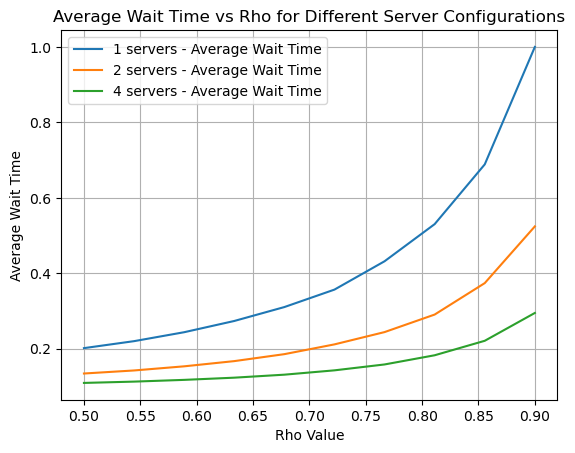

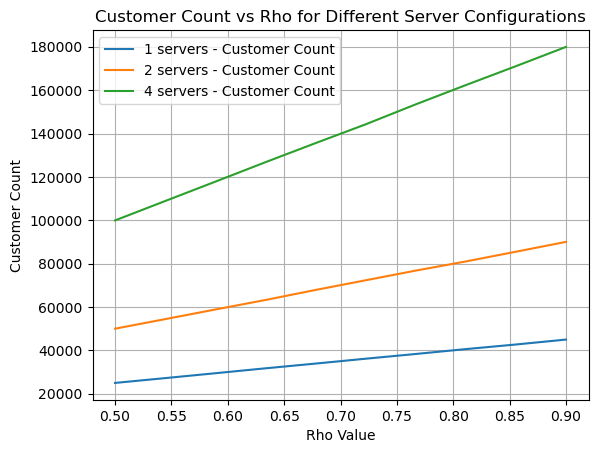

In [3]:


# Simulation parameters
SIM_TIME = 5000
mu_rate = 10  # service rate
NUM_RUNS = 20  # Number of times to run the simulation for better statistics

# Define the customer process
def customer(env, server, wait_times):
    arrival_time = env.now
    with server.request() as request:
        yield request
        yield env.timeout(random.expovariate(mu_rate))
        wait_times.append(env.now - arrival_time)

# Define the simulation function
def run_simulation(n_servers, lambda_rate):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=n_servers)
    wait_times = []
    customer_count = 0

    def customer_arrivals(env, server, wait_times):
        nonlocal customer_count
        while True:
            yield env.timeout(random.expovariate(lambda_rate))
            env.process(customer(env, server, wait_times))
            customer_count += 1

    env.process(customer_arrivals(env, server, wait_times))
    env.run(until=SIM_TIME)
    return statistics.mean(wait_times) if wait_times else 0, customer_count

# Run the simulation for different rho values and server counts
rho_values = np.linspace(0.5, 0.9, 10) 
server_counts = [1, 2, 4]
results = {}
customer_counts = {}

for n in server_counts:
    results[n] = {rho: [] for rho in rho_values}
    customer_counts[n] = {rho: [] for rho in rho_values}
    for rho in rho_values:
        for _ in range(NUM_RUNS):
            lambda_rate = n * mu_rate * rho
            mean_wait, count = run_simulation(n, lambda_rate)
            results[n][rho].append(mean_wait)
            customer_counts[n][rho].append(count)

# Calculate the average of the simulation runs
average_results = {n: [] for n in server_counts}
average_customer_counts = {n: [] for n in server_counts}

for n in server_counts:
    for rho in rho_values:
        average_results[n].append(statistics.mean(results[n][rho]))
        average_customer_counts[n].append(statistics.mean(customer_counts[n][rho]))

# Plot the average waiting time
for n in server_counts:
    plt.plot(rho_values, average_results[n], label=f'{n} servers - Average Wait Time')

plt.xlabel('Rho Value')
plt.ylabel('Average Wait Time')
plt.title('Average Wait Time vs Rho for Different Server Configurations')
plt.legend()
plt.grid(True)
plt.show()

# Plot the customer count
plt.figure()  # Start a new figure for the customer count
for n in server_counts:
    plt.plot(rho_values, average_customer_counts[n], label=f'{n} servers - Customer Count')

plt.xlabel('Rho Value')
plt.ylabel('Customer Count')
plt.title('Customer Count vs Rho for Different Server Configurations')
plt.legend()
plt.grid(True)
plt.show()


Kruskal-Wallis test p-value for ρ=0.85: 3.3381984424767097e-29
Kruskal-Wallis test p-value for ρ=0.9: 3.7028500101849083e-29
Kruskal-Wallis test p-value for ρ=0.91: 6.38316710462781e-29
Kruskal-Wallis test p-value for ρ=0.92: 1.4463448162930018e-28
Kruskal-Wallis test p-value for ρ=0.93: 1.649378413546038e-28
Kruskal-Wallis test p-value for ρ=0.94: 2.2746819317634723e-26
Kruskal-Wallis test p-value for ρ=0.95: 1.3791240026251675e-25
Kruskal-Wallis test p-value for ρ=0.96: 8.164716682807464e-25
Kruskal-Wallis test p-value for ρ=0.97: 2.52587854198241e-21
Kruskal-Wallis test p-value for ρ=0.98: 6.199718480803182e-14
Kruskal-Wallis test p-value for ρ=0.99: 1.0972835872776502e-14


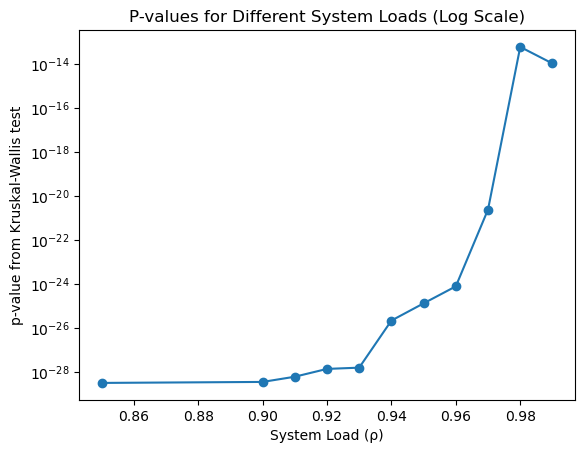

In [5]:
from scipy.stats import kruskal
# Set the random seed for reproducibility
random.seed(42)

# Define the customer process
def customer(env, server, service_rate):
    """Customer process."""
    arrival_time = env.now
    with server.request() as request:
        yield request
        yield env.timeout(random.expovariate(service_rate))
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)

# Define the environment setup
def setup(env, n_servers, service_rate, arrival_rate):
    """Setup the simulation environment."""
    server = simpy.Resource(env, capacity=n_servers)
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, server, service_rate))

# Run simulation and collect wait times for a given number of servers and arrival rate
def run_simulation(n_servers, service_rate, arrival_rate, sim_time):
    env = simpy.Environment()
    global wait_times
    wait_times = []  # Initialize wait times for this simulation run
    env.process(setup(env, n_servers, service_rate, arrival_rate))
    env.run(until=sim_time)
    return wait_times

# Parameters
servers = [1, 2, 4]  # Number of servers
mu_rate = 1.0  # Service rate
sim_time = 5000  # Simulation time
runs = 50  # Number of runs to simulate
rho_values = [0.85, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95,0.96,0.97,0.98,0.99]
# Run simulations and apply Kruskal-Wallis test
all_results = {rho: {n: [] for n in servers} for rho in rho_values}
p_values = []

# For each system load
for rho in rho_values:
    # For each server configuration
    for n in servers:
        lambda_rate = rho * n * mu_rate   # corrected lambda rate
        # Collect wait times for a number of runs
        all_wait_times = [run_simulation(n, mu_rate, lambda_rate, sim_time) for _ in range(runs)]
        # Calculate average wait times
        avg_wait_times = [np.mean(wt) for wt in all_wait_times if wt]
        all_results[rho][n] = avg_wait_times
    
    # Now perform the Kruskal-Wallis test for each rho value
    # Extract the list of average wait times for each server configuration
    data = [all_results[rho][n] for n in servers if all_results[rho][n]]
    if len(data) == len(servers):  # Ensure we have data for all server configurations
        stat, p = kruskal(*data)
        p_values.append(p)
        print(f"Kruskal-Wallis test p-value for ρ={rho}: {p}")
    else:
        print(f"Insufficient data for Kruskal-Wallis test for ρ={rho}")


# Plot p-values with a logarithmic scale on the y-axis
plt.plot(rho_values, p_values, marker='o')
plt.xlabel('System Load (ρ)')
plt.ylabel('p-value from Kruskal-Wallis test')
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title('P-values for Different System Loads (Log Scale)')
plt.show()

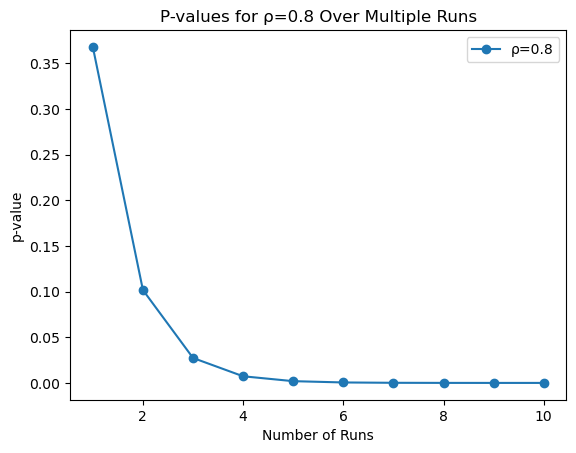

In [6]:
# Set the random seed for reproducibility
random.seed(42)

def customer(env, server, service_rate, wait_times):
    """Customer process."""
    arrival_time = env.now
    with server.request() as request:
        yield request
        yield env.timeout(random.expovariate(service_rate))
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)

def setup(env, n_servers, service_rate, arrival_rate, wait_times):
    """Set up the simulation environment."""
    server = simpy.Resource(env, capacity=n_servers)
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(customer(env, server, service_rate, wait_times))

def run_simulation(n_servers, service_rate, arrival_rate, sim_time):
    """Run the simulation and return all wait times."""
    env = simpy.Environment()
    wait_times = []
    env.process(setup(env, n_servers, service_rate, arrival_rate, wait_times))
    env.run(until=sim_time)
    return wait_times

# Parameters
servers = [1, 2, 4]
target_load = 0.8  # Set the target load for which we want to plot the p-values
sim_time = 10000
num_runs = 10
service_rate = 10

# Run the simulations for the target load
results = {n: [] for n in servers}
for n in servers:
    lambda_rate = target_load * service_rate
    for _ in range(num_runs):
        wait_times = run_simulation(n, service_rate, lambda_rate / n, sim_time)
        average_wait = np.mean(wait_times) if wait_times else 0
        results[n].append(average_wait)

# Perform Kruskal-Wallis tests for the target load and accumulate the p-values
p_values = []
for run in range(1, num_runs + 1):
    samples = [results[n][:run] for n in servers]
    statistic, p_value = kruskal(*samples)
    p_values.append(p_value)

# Plot the accumulated p-values for the target load
plt.plot(range(1, num_runs + 1), p_values, marker='o', label=f'ρ={target_load}')

plt.xlabel('Number of Runs')
plt.ylabel('p-value')
plt.title(f'P-values for ρ={target_load} Over Multiple Runs')
plt.legend()
plt.show()

### Q3

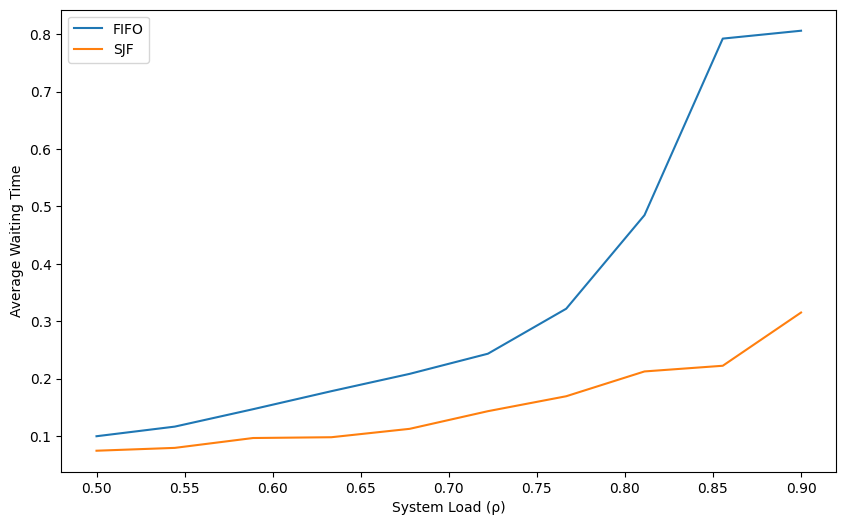

In [6]:
#Question 3
import heapq

def simulate_queue_wait_time(lambda_rate, mu_rate, SIM_TIME, is_sjf=False):
    FEL = [(random.expovariate(lambda_rate), 'arrival', random.expovariate(mu_rate))]
    sjf_queue = []

    current_time = 0
    num_in_queue = 0

    total_wait_time = 0
    total_jobs = 0

    while current_time < SIM_TIME:
        event_time, event_type, job_size = heapq.heappop(FEL)
        current_time = event_time

        if event_type == 'arrival':
            heapq.heappush(FEL, (current_time + random.expovariate(lambda_rate), 'arrival', random.expovariate(mu_rate)))
            if num_in_queue == 0:
                heapq.heappush(FEL, (current_time + job_size, 'departure', job_size))
            else:
                if is_sjf:
                    heapq.heappush(sjf_queue, (job_size, current_time, 'arrival'))
                else:
                    sjf_queue.append((job_size, current_time, 'arrival'))
            num_in_queue += 1
        elif event_type == 'departure':
            total_jobs += 1
            if num_in_queue > 0:
                num_in_queue -= 1
                if num_in_queue > 0:
                    if is_sjf:
                        next_job_size, next_arrival_time, _ = heapq.heappop(sjf_queue)
                    else:
                        next_job_size, next_arrival_time, _ = sjf_queue.pop(0)
                    wait_time = current_time - next_arrival_time
                    total_wait_time += wait_time
                    heapq.heappush(FEL, (current_time + next_job_size, 'departure', next_job_size))

    return total_wait_time / total_jobs if total_jobs > 0 else 0

lambda_rate = 8  
mu_rate = 10    
SIM_TIME = 1000  

rho_values = np.linspace(0.5, 0.9, 10)
avg_wait_times_fifo = []
avg_wait_times_sjf = []

for rho in rho_values:
    new_lambda_rate = rho * mu_rate
    avg_wait_time_fifo = simulate_queue_wait_time(new_lambda_rate, mu_rate, SIM_TIME, is_sjf=False)
    avg_wait_time_sjf = simulate_queue_wait_time(new_lambda_rate, mu_rate, SIM_TIME, is_sjf=True)

    avg_wait_times_fifo.append(avg_wait_time_fifo)
    avg_wait_times_sjf.append(avg_wait_time_sjf)

plt.figure(figsize=(10, 6))
plt.plot(rho_values, avg_wait_times_fifo, label='FIFO')
plt.plot(rho_values, avg_wait_times_sjf, label='SJF')
plt.xlabel('System Load (ρ)')
plt.ylabel('Average Waiting Time')
#plt.title('Average Waiting Time vs System Load')
plt.legend()
plt.show()


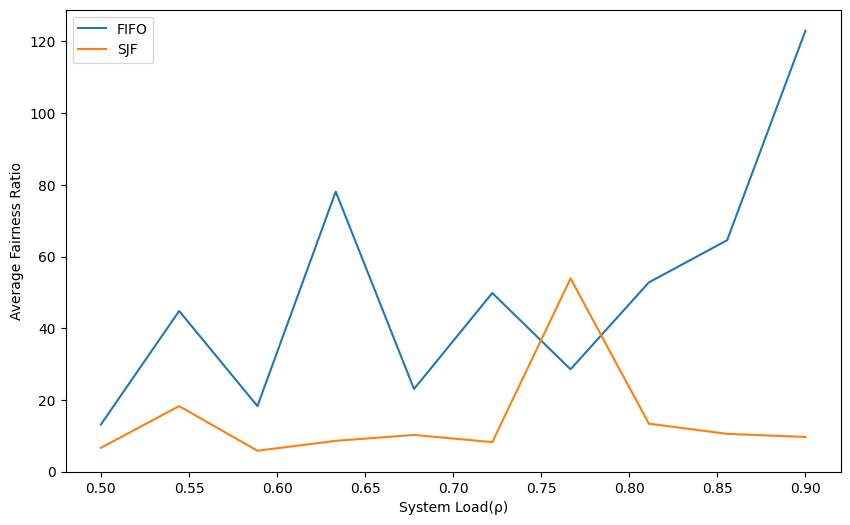

In [7]:
# faireness
def simulate_queue_fairness(lambda_rate, mu_rate, SIM_TIME, is_sjf=False):
    FEL = [(random.expovariate(lambda_rate), 'arrival', random.expovariate(mu_rate))]
    sjf_queue = []

    current_time = 0
    num_in_queue = 0

    fairness_ratios = []  #Stores the ratio of waiting time to service time for each job

    while current_time < SIM_TIME:
        event_time, event_type, job_size = heapq.heappop(FEL)
        current_time = event_time

        if event_type == 'arrival':
            heapq.heappush(FEL, (current_time + random.expovariate(lambda_rate), 'arrival', random.expovariate(mu_rate)))
            if num_in_queue == 0:
                heapq.heappush(FEL, (current_time + job_size, 'departure', job_size))
            else:
                if is_sjf:
                    heapq.heappush(sjf_queue, (job_size, current_time, 'arrival'))
                else:
                    sjf_queue.append((job_size, current_time, 'arrival'))
            num_in_queue += 1
        elif event_type == 'departure':
            if num_in_queue > 0:
                num_in_queue -= 1
                if num_in_queue > 0:
                    if is_sjf:
                        next_job_size, next_arrival_time, _ = heapq.heappop(sjf_queue)
                    else:
                        next_job_size, next_arrival_time, _ = sjf_queue.pop(0)
                    wait_time = current_time - next_arrival_time
                    fairness_ratio = wait_time / next_job_size if next_job_size > 0 else 0
                    fairness_ratios.append(fairness_ratio)
                    heapq.heappush(FEL, (current_time + next_job_size, 'departure', next_job_size))

    avg_fairness_ratio = sum(fairness_ratios) / len(fairness_ratios) if fairness_ratios else 0
    return avg_fairness_ratio

avg_fairness_ratios_fifo = []
avg_fairness_ratios_sjf = []

for rho in rho_values:
    new_lambda_rate = rho * mu_rate
    avg_fairness_ratio_fifo = simulate_queue_fairness(new_lambda_rate, mu_rate, SIM_TIME, is_sjf=False)
    avg_fairness_ratio_sjf = simulate_queue_fairness(new_lambda_rate, mu_rate, SIM_TIME, is_sjf=True)

    avg_fairness_ratios_fifo.append(avg_fairness_ratio_fifo)
    avg_fairness_ratios_sjf.append(avg_fairness_ratio_sjf)

plt.figure(figsize=(10, 6))
plt.plot(rho_values, avg_fairness_ratios_fifo, label='FIFO')
plt.plot(rho_values, avg_fairness_ratios_sjf, label='SJF')
plt.xlabel('System Load(ρ)')
plt.ylabel('Average Fairness Ratio')
#plt.title('Average Fairness Ratio vs System Load')
plt.legend()
plt.show()


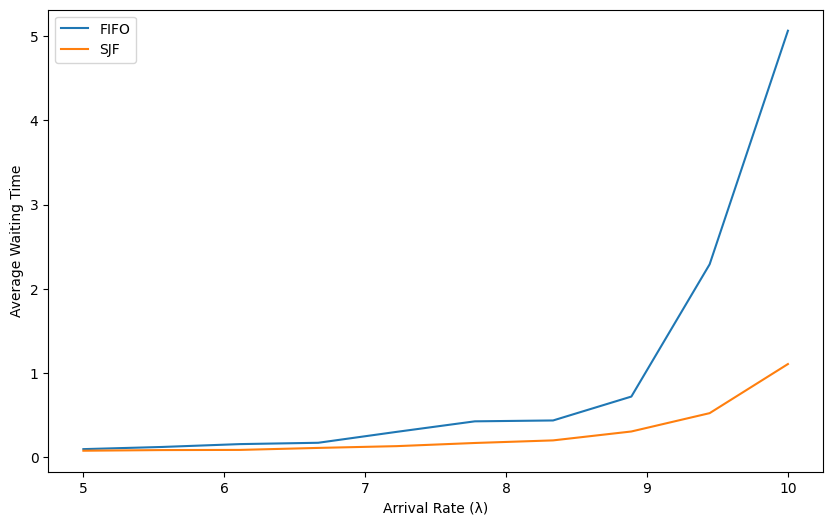

In [8]:
# the simulation for FIFO and SJF under Poisson arrival
def simulate_queue(lambda_rate, mu_rate, SIM_TIME, is_sjf=False):
    FEL = []
    current_time = 0
    num_in_queue = 0
    total_wait_time = 0
    total_jobs = 0
    sjf_queue = []

    # Generate initial arrival
    FEL.append((random.expovariate(lambda_rate), 'arrival', random.expovariate(mu_rate)))

    while current_time < SIM_TIME:
        event_time, event_type, job_size = heapq.heappop(FEL)
        current_time = event_time

        if event_type == 'arrival':
            # Generate next arrival
            heapq.heappush(FEL, (current_time + random.expovariate(lambda_rate), 'arrival', random.expovariate(mu_rate)))
            if num_in_queue == 0:
                # If the queue is empty, schedule a departure
                heapq.heappush(FEL, (current_time + job_size, 'departure', job_size))
            else:
                # Add the job to the queue
                if is_sjf:
                    # Add to the priority queue sorted by job size
                    heapq.heappush(sjf_queue, (job_size, current_time))
                else:
                    # Add to the end of the queue
                    sjf_queue.append((job_size, current_time))
            num_in_queue += 1
        elif event_type == 'departure':
            # Departure event
            total_jobs += 1
            if num_in_queue > 0:
                num_in_queue -= 1
                if num_in_queue > 0:
                    if is_sjf:
                        # Pop the next job based on job size for SJF
                        next_job_size, next_arrival_time = heapq.heappop(sjf_queue)
                    else:
                        # Pop the next job based on arrival order for FIFO
                        next_job_size, next_arrival_time = sjf_queue.pop(0)
                    total_wait_time += current_time - next_arrival_time
                    heapq.heappush(FEL, (current_time + next_job_size, 'departure', next_job_size))

    # Calculate the average wait time
    avg_wait_time = total_wait_time / total_jobs if total_jobs > 0 else 0
    return avg_wait_time

mu_rate = 10  
SIM_TIME = 1000  
lambda_rates = np.linspace(5, 10, 10)  # Varying arrival rates


avg_wait_times_fifo = []
avg_wait_times_sjf = []

for lambda_rate in lambda_rates:
    avg_wait_fifo = simulate_queue(lambda_rate, mu_rate, SIM_TIME, is_sjf=False)
    avg_wait_sjf = simulate_queue(lambda_rate, mu_rate, SIM_TIME, is_sjf=True)
    
    avg_wait_times_fifo.append(avg_wait_fifo)
    avg_wait_times_sjf.append(avg_wait_sjf)

plt.figure(figsize=(10, 6))
plt.plot(lambda_rates, avg_wait_times_fifo, label='FIFO')
plt.plot(lambda_rates, avg_wait_times_sjf, label='SJF')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Average Waiting Time')
#plt.title('Average Waiting Time vs Arrival Rate (Poisson Arrival)')
plt.legend()
plt.show()



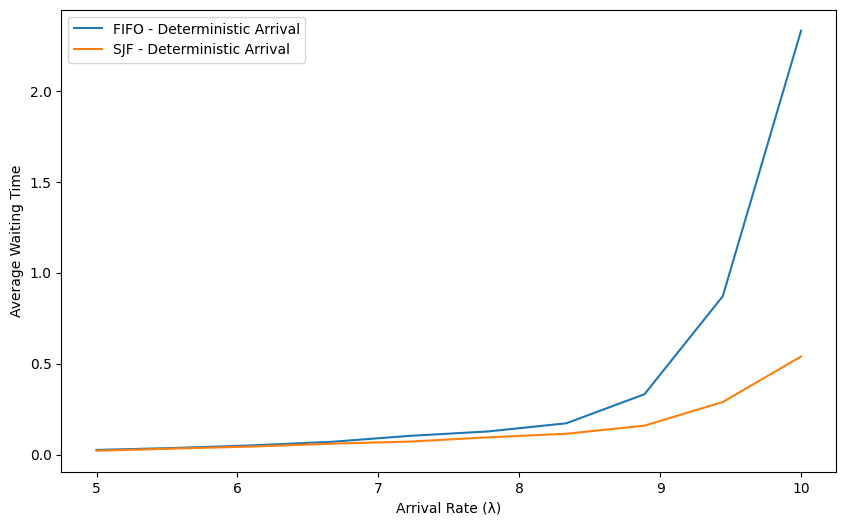

In [9]:
# the simulation for FIFO and SJF under Deterministic arrival

def simulate_queue_deterministic(lambda_rate, mu_rate, SIM_TIME, is_sjf=False):
    FEL = []
    sjf_queue = []
    current_time = 0
    num_in_queue = 0
    total_wait_time = 0
    total_jobs = 0

    # initial arrival
    next_arrival_time = 1 / lambda_rate  # deterministic arrival interval
    FEL.append((next_arrival_time, 'arrival'))

    # 仿真循环
    while current_time < SIM_TIME:
        if not FEL:
            break
        event_time, event_type = heapq.heappop(FEL)
        current_time = event_time

        if event_type == 'arrival':
            # next arrival
            next_arrival_time = current_time + 1 / lambda_rate
            heapq.heappush(FEL, (next_arrival_time, 'arrival'))

            job_size = random.expovariate(mu_rate)
            if num_in_queue == 0:
                heapq.heappush(FEL, (current_time + job_size, 'departure'))
            else:
                if is_sjf:
                    heapq.heappush(sjf_queue, (job_size, current_time))
                else:
                    sjf_queue.append((job_size, current_time))
            num_in_queue += 1
        elif event_type == 'departure':
            total_jobs += 1
            if num_in_queue > 0:
                num_in_queue -= 1
                if num_in_queue > 0:
                    if is_sjf:
                        next_job_size, next_arrival_time = heapq.heappop(sjf_queue)
                    else:
                        next_job_size, next_arrival_time = sjf_queue.pop(0)
                    total_wait_time += current_time - next_arrival_time
                    heapq.heappush(FEL, (current_time + next_job_size, 'departure'))

    return total_wait_time / total_jobs if total_jobs > 0 else 0

avg_wait_times_fifo_deterministic = []
avg_wait_times_sjf_deterministic = []


for lambda_rate in lambda_rates:
    avg_wait_time_fifo = simulate_queue_deterministic(lambda_rate, mu_rate, SIM_TIME, is_sjf=False)
    avg_wait_time_sjf = simulate_queue_deterministic(lambda_rate, mu_rate, SIM_TIME, is_sjf=True)

    avg_wait_times_fifo_deterministic.append(avg_wait_time_fifo)
    avg_wait_times_sjf_deterministic.append(avg_wait_time_sjf)

plt.figure(figsize=(10, 6))
plt.plot(lambda_rates, avg_wait_times_fifo_deterministic, label='FIFO - Deterministic Arrival')
plt.plot(lambda_rates, avg_wait_times_sjf_deterministic, label='SJF - Deterministic Arrival')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Average Waiting Time')
#plt.title('Average Waiting Time vs Arrival Rate (Deterministic Arrival)')
plt.legend()
plt.show()



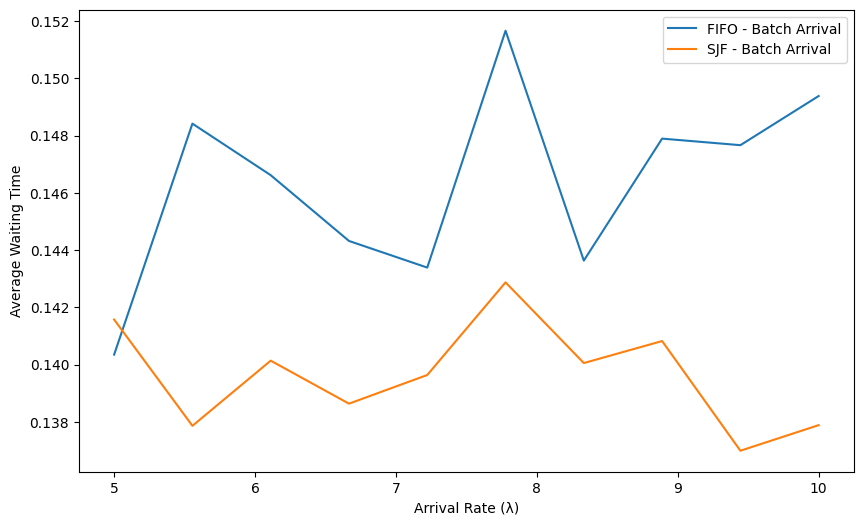

In [11]:
# the simulation for FIFO and SJF under Batch arrival

def simulate_queue_batch(lambda_rate, mu_rate, SIM_TIME, batch_size, is_sjf=False):
    FEL = []
    current_time = 0
    num_in_queue = 0
    total_wait_time = 0
    total_jobs = 0
    sjf_queue = []

    while current_time < SIM_TIME:
        if not FEL:
            next_arrival_time = current_time + random.expovariate(lambda_rate / batch_size)
            for _ in range(batch_size):
                job_size = random.expovariate(mu_rate)
                FEL.append((next_arrival_time, 'arrival', job_size))

        event_time, event_type, job_size = heapq.heappop(FEL)
        current_time = event_time

        if event_type == 'arrival':
            if num_in_queue == 0:
                heapq.heappush(FEL, (current_time + job_size, 'departure', job_size))
            else:
                if is_sjf:
                    heapq.heappush(sjf_queue, (job_size, current_time, 'arrival'))
                else:
                    sjf_queue.append((job_size, current_time, 'arrival'))
            num_in_queue += 1
        elif event_type == 'departure':
            total_jobs += 1
            if num_in_queue > 0:
                num_in_queue -= 1
                if num_in_queue > 0:
                    if is_sjf:
                        next_job_size, next_arrival_time, _ = heapq.heappop(sjf_queue)
                    else:
                        next_job_size, next_arrival_time, _ = sjf_queue.pop(0)
                    wait_time = current_time - next_arrival_time
                    total_wait_time += wait_time
                    heapq.heappush(FEL, (current_time + next_job_size, 'departure', next_job_size))

    avg_wait_time = total_wait_time / total_jobs if total_jobs > 0 else 0
    return avg_wait_time

batch_size = 5  # Assume that 5 jobs in each batch arrive at the same time

avg_wait_times_fifo_batch = []
avg_wait_times_sjf_batch = []

for lambda_rate in lambda_rates:
    avg_wait_time_fifo_batch = simulate_queue_batch(lambda_rate, mu_rate, SIM_TIME, batch_size, is_sjf=False)
    avg_wait_time_sjf_batch = simulate_queue_batch(lambda_rate, mu_rate, SIM_TIME, batch_size, is_sjf=True)

    avg_wait_times_fifo_batch.append(avg_wait_time_fifo_batch)
    avg_wait_times_sjf_batch.append(avg_wait_time_sjf_batch)

plt.figure(figsize=(10, 6))
plt.plot(lambda_rates, avg_wait_times_fifo_batch, label='FIFO - Batch Arrival')
plt.plot(lambda_rates, avg_wait_times_sjf_batch, label='SJF - Batch Arrival')
plt.xlabel('Arrival Rate (λ)')
plt.ylabel('Average Waiting Time')
#plt.title('Average Waiting Time vs Arrival Rate (Batch Arrival)')
plt.legend()
plt.show()

